In [1]:
%matplotlib inline

import os
import sys
genre_class_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print("Loading Genre_Classification system from path", genre_class_path)
sys.path.append(genre_class_path)

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import random
import pickle

Loading Genre_Classification system from path /mnt/d/UNIV NOTES/Y4S1/DSA4199/genre_classification


2022-11-15 16:58:43.773271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 16:58:43.774228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from nltk import download
from sklearn import svm
from sklearn.metrics import accuracy_score

download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kathyij74/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
dataset_wkspc = os.path.join(genre_class_path, 'workspace', 'gb_input')
data_path = os.path.join(dataset_wkspc, 'bigram.csv')

bigram_df = pd.read_csv(data_path)
bigram_df = bigram_df.iloc[:,1:]

In [4]:
dataset_wkspc = os.path.join(genre_class_path, 'workspace', 'gb_input')
data_path = os.path.join(dataset_wkspc, 'data_index.json')

with open(data_path) as f:
    data_json = json.load(f)

In [5]:
index = []
for entry in data_json:
    index.append(entry['index'])

In [6]:
index[:10]

['10002',
 '10005',
 '10008',
 '10046',
 '10067',
 '10094',
 '10109',
 '10124',
 '1014',
 '10234']

In [7]:
bigram_df.index = index

In [8]:
bigram_df.head()

,"('JJS', 'TO')","('FW', 'MD')","('EX', 'FW')","('DT', 'JJR')","('EX', 'VBG')","('UH', 'PDT')","('JJS', 'NN')","('PDT', 'RP')","('DT', 'RP')","('NNP', 'VBN')",...,"('UH', 'RB')","('PRP', 'RBR')","('NN', 'NNPS')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBS', 'VBN')","('RBR', 'TO')",subjects
10002,1,0,0,28,0,0,10,0,0,1,...,0,4,0,59,23,5,14,0,2,5
10005,2,0,0,60,1,0,49,0,0,1,...,0,5,0,102,28,9,64,1,2,5
10008,4,0,0,32,1,0,33,0,2,1,...,0,5,0,64,40,7,27,0,2,5
10046,8,0,0,74,0,0,76,0,0,1,...,0,3,0,66,34,4,46,0,4,3
10067,0,2,0,29,7,0,46,0,5,1,...,0,6,0,92,28,10,35,1,2,2


In [9]:
bigram_df['subjects'].value_counts()

5    1742
1     523
2     469
4     427
6     374
3     354
Name: subjects, dtype: int64

In [10]:
random.seed(42)

train = random.sample(range(0, len(bigram_df)), int(len(bigram_df)*0.7))
test = [x for x in range(0, len(bigram_df)) if x not in train]

print(train[:20])
print(test[:20])
print(len(train))
print(len(test))

[2619, 456, 102, 3037, 1126, 1003, 914, 571, 3016, 419, 2771, 3033, 3654, 2233, 356, 2418, 1728, 130, 122, 383]
[0, 5, 7, 9, 12, 15, 17, 19, 20, 21, 27, 30, 35, 36, 37, 40, 42, 43, 44, 45]
2722
1167


In [11]:
train_df = bigram_df.iloc[train,]
test_df = bigram_df.iloc[test,]

print(train_df.shape)
print(test_df.shape)

(2722, 1119)
(1167, 1119)


In [12]:
train_df.head()

,"('JJS', 'TO')","('FW', 'MD')","('EX', 'FW')","('DT', 'JJR')","('EX', 'VBG')","('UH', 'PDT')","('JJS', 'NN')","('PDT', 'RP')","('DT', 'RP')","('NNP', 'VBN')",...,"('UH', 'RB')","('PRP', 'RBR')","('NN', 'NNPS')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBS', 'VBN')","('RBR', 'TO')",subjects
6407,15,0,0,149,1,0,181,0,0,1,...,0,11,0,194,28,17,155,2,4,3
20719,5,1,0,42,1,0,52,0,3,1,...,0,2,1,101,34,10,21,1,2,4
12725,4,0,0,40,0,0,106,0,0,0,...,0,6,0,107,26,11,51,3,10,3
24104,0,0,0,6,0,0,4,0,0,0,...,0,1,0,13,19,3,9,0,0,5
30004,0,0,0,3,0,0,2,0,0,1,...,0,2,0,9,19,2,0,0,1,5


In [13]:
train_df['subjects'].value_counts()

5    1231
1     378
2     318
4     296
6     258
3     241
Name: subjects, dtype: int64

In [14]:
test_df.head()

,"('JJS', 'TO')","('FW', 'MD')","('EX', 'FW')","('DT', 'JJR')","('EX', 'VBG')","('UH', 'PDT')","('JJS', 'NN')","('PDT', 'RP')","('DT', 'RP')","('NNP', 'VBN')",...,"('UH', 'RB')","('PRP', 'RBR')","('NN', 'NNPS')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBS', 'VBN')","('RBR', 'TO')",subjects
10002,1,0,0,28,0,0,10,0,0,1,...,0,4,0,59,23,5,14,0,2,5
10094,7,0,0,61,2,0,54,0,2,0,...,0,2,0,98,32,10,36,0,4,3
10124,2,0,0,19,0,0,25,0,5,0,...,0,0,0,48,25,4,10,1,0,6
10234,0,1,0,41,0,0,37,0,0,0,...,0,2,0,52,38,3,18,0,3,3
10372,3,1,0,44,0,0,79,0,2,1,...,0,2,0,71,35,6,36,0,2,6


In [15]:
test_df['subjects'].value_counts()

5    511
2    151
1    145
4    131
6    116
3    113
Name: subjects, dtype: int64

In [16]:
features_col = train_df.iloc[:,:-1]
sparse = {}
for feature in features_col.columns:
    sparse[feature] = ((features_col[feature] == 0).sum()/len(features_col))*100
non_sparse = [x for x in sparse.keys() if sparse[x] <= 80]

In [17]:
features_col.head()

,"('JJS', 'TO')","('FW', 'MD')","('EX', 'FW')","('DT', 'JJR')","('EX', 'VBG')","('UH', 'PDT')","('JJS', 'NN')","('PDT', 'RP')","('DT', 'RP')","('NNP', 'VBN')",...,"('WRB', 'VBZ')","('UH', 'RB')","('PRP', 'RBR')","('NN', 'NNPS')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBS', 'VBN')","('RBR', 'TO')"
6407,15,0,0,149,1,0,181,0,0,1,...,20,0,11,0,194,28,17,155,2,4
20719,5,1,0,42,1,0,52,0,3,1,...,10,0,2,1,101,34,10,21,1,2
12725,4,0,0,40,0,0,106,0,0,0,...,9,0,6,0,107,26,11,51,3,10
24104,0,0,0,6,0,0,4,0,0,0,...,1,0,1,0,13,19,3,9,0,0
30004,0,0,0,3,0,0,2,0,0,1,...,0,0,2,0,9,19,2,0,0,1


In [18]:
# remove sparse columns aka columns with 0 values more than 80%
features_col = train_df.iloc[:, :-1]
subjects = train_df.iloc[:, -1:]
train_index = train_df.index
sparse = {}
for feature in features_col.columns:
    sparse[feature] = ((features_col[feature] == 0).sum()/len(features_col))*100
non_sparse = [x for x in sparse.keys() if sparse[x] <= 80]

In [19]:
body_length = {}
for entry in data_json:
    body_length[entry['index']] = entry['body_length']

In [20]:
body_length['6407']

225019

In [21]:
train_index[:10]

Index(['6407', '20719', '12725', '24104', '30004', '29060', '2789', '22540',
       '2344', '20152'],
      dtype='object')

In [22]:
# rescale the data by dividing it with row sum

train_df = train_df[non_sparse]
for number in train_index:
    train_df.loc[number,:] = train_df.loc[number,:].div(int(body_length[number]))
train_df['subjects'] = subjects

In [23]:
train_df.head()

,"('JJS', 'TO')","('DT', 'JJR')","('EX', 'VBG')","('JJS', 'NN')","('DT', 'RP')","('NNP', 'VBN')","('IN', 'WDT')","('CC', 'MD')","('VBZ', 'NNP')","('PRP', 'VBP')",...,"('MD', 'VB')","('PRP$', 'JJR')","('WRB', 'VBZ')","('PRP', 'RBR')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBR', 'TO')",subjects
6407,0.000067,0.000662,0.000004,0.000804,0.00000,0.000004,0.001933,0.000493,0.000000,0.004377,...,0.009270,0.000053,0.000089,0.000049,0.000862,0.000124,0.000076,0.000689,0.000018,3
20719,0.000051,0.000426,0.000010,0.000528,0.00003,0.000010,0.000924,0.000274,0.000020,0.005452,...,0.011331,0.000020,0.000102,0.000020,0.001026,0.000345,0.000102,0.000213,0.000020,4
12725,0.000034,0.000342,0.000000,0.000907,0.00000,0.000000,0.001481,0.000317,0.000009,0.002157,...,0.008664,0.000103,0.000077,0.000051,0.000916,0.000223,0.000094,0.000437,0.000086,3
24104,0.000000,0.000296,0.000000,0.000197,0.00000,0.000000,0.000493,0.000345,0.000099,0.007845,...,0.011101,0.000000,0.000049,0.000049,0.000641,0.000937,0.000148,0.000444,0.000000,5
30004,0.000000,0.000387,0.000000,0.000258,0.00000,0.000129,0.001031,0.000516,0.000129,0.006961,...,0.011343,0.000129,0.000000,0.000258,0.001160,0.002449,0.000258,0.000000,0.000129,5


In [24]:
from sklearn import svm
from matplotlib import pyplot as plt

X = train_df.iloc[:, :-1].to_numpy()
y = train_df.iloc[:, -1:].to_numpy().flatten()

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

In [25]:
clf2 = svm.LinearSVC(loss='hinge', max_iter=100000)
clf2.fit(X, y)

LinearSVC(loss='hinge', max_iter=100000)

In [26]:
clf3 = svm.SVC(kernel='linear', class_weight='balanced')
clf3.fit(X, y)

SVC(class_weight='balanced', kernel='linear')

In [27]:
clf4 = svm.LinearSVC(loss='hinge', class_weight='balanced', max_iter=100000)
clf4.fit(X, y)

LinearSVC(class_weight='balanced', loss='hinge', max_iter=100000)

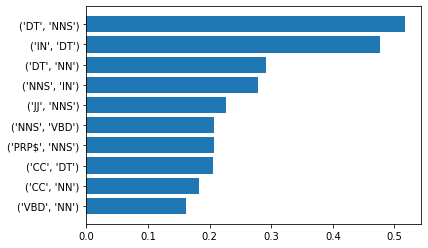

In [28]:
# check feature importance

def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(10), imp[-10:], align='center')
    plt.yticks(range(10), names[-10:])
    plt.show()
    
f_importances(clf.coef_[0], non_sparse)

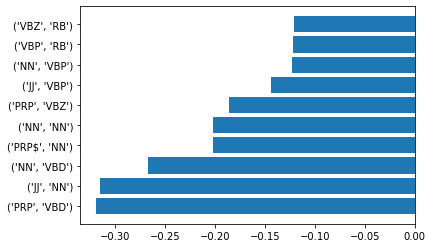

In [29]:
# check feature importance

def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(10), imp[:10], align='center')
    plt.yticks(range(10), names[:10])
    plt.show()
    
f_importances(clf.coef_[0], non_sparse)

In [30]:
clf2.coef_.shape

(6, 697)

In [31]:
# preprocess test data
test_subjects = test_df['subjects']
test_index = test_df.index
test_df = test_df[non_sparse]
#test_df = test_df.div(test_df.sum(axis=1), axis=0)
for number in test_index:
    test_df.loc[number,:] = test_df.loc[number,:].div(int(body_length[number]))
test_df['subjects'] = test_subjects

In [32]:
test_df.head()

,"('JJS', 'TO')","('DT', 'JJR')","('EX', 'VBG')","('JJS', 'NN')","('DT', 'RP')","('NNP', 'VBN')","('IN', 'WDT')","('CC', 'MD')","('VBZ', 'NNP')","('PRP', 'VBP')",...,"('MD', 'VB')","('PRP$', 'JJR')","('WRB', 'VBZ')","('PRP', 'RBR')","('VBG', 'PRP')","('NN', 'CD')","('VBN', 'CD')","('IN', 'WP')","('RBR', 'TO')",subjects
10002,0.000015,0.000426,0.00000,0.000152,0.000000,0.000015,0.001339,0.000502,0.000000,0.001186,...,0.006130,0.000046,0.000000,0.000061,0.000897,0.000350,0.000076,0.000213,0.000030,5
10094,0.000070,0.000606,0.00002,0.000536,0.000020,0.000000,0.000824,0.000516,0.000010,0.003734,...,0.008918,0.000040,0.000129,0.000020,0.000973,0.000318,0.000099,0.000358,0.000040,3
10124,0.000035,0.000333,0.00000,0.000438,0.000088,0.000000,0.000368,0.000473,0.000018,0.007266,...,0.007984,0.000018,0.000088,0.000000,0.000840,0.000438,0.000070,0.000175,0.000000,6
10234,0.000000,0.000455,0.00000,0.000411,0.000000,0.000000,0.000477,0.000289,0.000011,0.004784,...,0.007148,0.000011,0.000144,0.000022,0.000577,0.000422,0.000033,0.000200,0.000033,3
10372,0.000027,0.000389,0.00000,0.000699,0.000018,0.000009,0.000239,0.000212,0.000044,0.005468,...,0.008830,0.000009,0.000106,0.000018,0.000628,0.000310,0.000053,0.000319,0.000018,6


In [33]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred = clf.predict(X_test)

In [34]:
pred

array([5, 5, 5, ..., 5, 5, 5])

In [35]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm = metrics.confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [36]:
cm

array([[  0,   0,   0,   0, 145,   0],
       [  0,   0,   0,   0, 151,   0],
       [  0,   0,   0,   0, 113,   0],
       [  0,   0,   0,   0, 131,   0],
       [  0,   0,   0,   0, 511,   0],
       [  0,   0,   0,   0, 116,   0]])

In [37]:
cm.diagonal()/cm.sum(axis=1)

array([0., 0., 0., 0., 1., 0.])

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.000     0.000     0.000       145
Detective and mystery stories      0.000     0.000     0.000       151
           Historical fiction      0.000     0.000     0.000       113
                 Love stories      0.000     0.000     0.000       131
              Science fiction      0.438     1.000     0.609       511
              Western stories      0.000     0.000     0.000       116

                     accuracy                          0.438      1167
                    macro avg      0.073     0.167     0.102      1167
                 weighted avg      0.192     0.438     0.267      1167



/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred2 = clf2.predict(X_test)

In [40]:
pred2

array([5, 3, 5, ..., 5, 5, 5])

In [41]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm2 = metrics.confusion_matrix(y_test, pred2)
cm_df2 = pd.DataFrame(cm2, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [42]:
cm2

array([[  6,   3,   3,   4, 129,   0],
       [  0,  12,   1,  15, 123,   0],
       [  1,   0,   8,   7,  97,   0],
       [  0,   4,   0,  39,  88,   0],
       [  1,   1,   0,   2, 507,   0],
       [  0,   0,   0,   3, 105,   8]])

In [43]:
cm2.diagonal()/cm2.sum(axis=1)

array([0.04137931, 0.0794702 , 0.07079646, 0.29770992, 0.99217221,
       0.06896552])

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred2, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.750     0.041     0.078       145
Detective and mystery stories      0.600     0.079     0.140       151
           Historical fiction      0.667     0.071     0.128       113
                 Love stories      0.557     0.298     0.388       131
              Science fiction      0.483     0.992     0.650       511
              Western stories      1.000     0.069     0.129       116

                     accuracy                          0.497      1167
                    macro avg      0.676     0.258     0.252      1167
                 weighted avg      0.609     0.497     0.381      1167



In [45]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred3 = clf3.predict(X_test)

In [46]:
pred3

array([6, 6, 6, ..., 6, 6, 6])

In [47]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm3 = metrics.confusion_matrix(y_test, pred3)
cm_df3 = pd.DataFrame(cm3, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [48]:
cm3

array([[  0,   0,   0,   0,   0, 145],
       [  0,   0,   0,   0,   0, 151],
       [  0,   0,   0,   0,   0, 113],
       [  0,   0,   0,   0,   0, 131],
       [  0,   0,   0,   0,   0, 511],
       [  0,   0,   0,   0,   0, 116]])

In [49]:
cm3.diagonal()/cm3.sum(axis=1)

array([0., 0., 0., 0., 0., 1.])

In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred3, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.000     0.000     0.000       145
Detective and mystery stories      0.000     0.000     0.000       151
           Historical fiction      0.000     0.000     0.000       113
                 Love stories      0.000     0.000     0.000       131
              Science fiction      0.000     0.000     0.000       511
              Western stories      0.099     1.000     0.181       116

                     accuracy                          0.099      1167
                    macro avg      0.017     0.167     0.030      1167
                 weighted avg      0.010     0.099     0.018      1167



/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kathyij74/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# make prediction

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1:].to_numpy().flatten()

pred4 = clf4.predict(X_test)

In [52]:
pred4

array([2, 3, 5, ..., 4, 4, 4])

In [53]:
# confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns

cm4 = metrics.confusion_matrix(y_test, pred4)
cm_df4 = pd.DataFrame(cm4, index = [1,2,3,4,5,6], columns = [1,2,3,4,5,6])
#plt.figure()
#sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Values')
#plt.xlabel('Predicted Values')
#plt.show()

In [54]:
cm4

array([[ 17,  14,  35,  20,  50,   9],
       [  1,  55,   7,  55,  28,   5],
       [  2,   1,  54,  20,  30,   6],
       [  0,   3,  10,  79,  33,   6],
       [  5,   6,   2,  10, 484,   4],
       [  1,   2,   9,  27,  34,  43]])

In [55]:
cm4.diagonal()/cm4.sum(axis=1)

array([0.11724138, 0.36423841, 0.47787611, 0.60305344, 0.94716243,
       0.37068966])

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred4, target_names=['Adventure stories','Detective and mystery stories','Historical fiction',
                                                        'Love stories','Science fiction','Western stories'], digits=3))

                               precision    recall  f1-score   support

            Adventure stories      0.654     0.117     0.199       145
Detective and mystery stories      0.679     0.364     0.474       151
           Historical fiction      0.462     0.478     0.470       113
                 Love stories      0.374     0.603     0.462       131
              Science fiction      0.734     0.947     0.827       511
              Western stories      0.589     0.371     0.455       116

                     accuracy                          0.627      1167
                    macro avg      0.582     0.480     0.481      1167
                 weighted avg      0.636     0.627     0.591      1167

